In [1]:
%load_ext autoreload
%autoreload 2

# Introduction of Plotly Plasma
In this notebook we demonstrate the use of the `plotly plasma` library to circunvent some of the shortcomings of the standard Plotly library. 



In [2]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np
import plasma
pio.renderers.default = "svg"

pio.templates.default = "plotly_white"

Lets first generate a dataset to work with

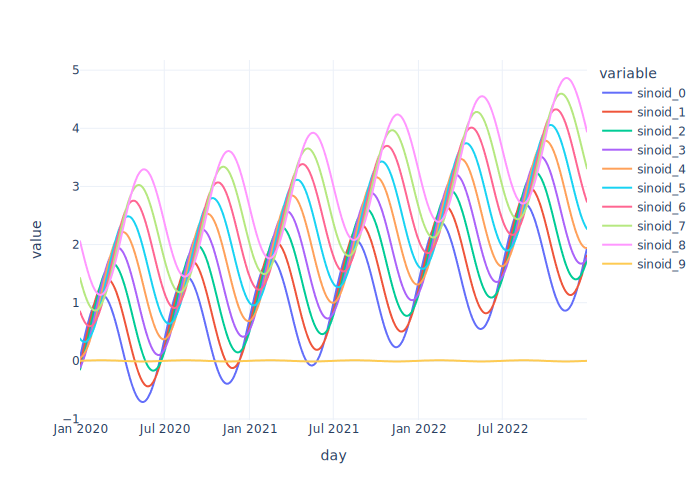

In [3]:
df_index = pd.date_range("2020-01-01", "2022-12-31", freq="D", name="day")
n_samples = df_index.shape[0]
x_array = np.linspace(-np.pi * 6, np.pi * 6, n_samples)
noise = np.random.random(df_index.shape[0])


def sinoid(x_lag, y_multiplier, linear_coefficient):
    return np.sin(x_array - x_lag) * y_multiplier + linear_coefficient


y_arrays = [
    sinoid(x_lag, y_multiplier, linear_coefficient) + x_array/20
    for x_lag, y_multiplier, linear_coefficient in zip(
        np.linspace(0, np.pi, 9), [1] * 9, np.linspace(1, 3, 9)
    )
]
y_arrays.append(sinoid(0, 0.01, 0))
data = pd.DataFrame(y_arrays).T.set_index(df_index)
data.columns = [f"sinoid_{i}" for i in range(10)]

px.line(data)


# Multiple y-axis
When the values of the metrics are in very different scales, plotly doesnt have an easy way to produce dual axis.

The default function will use the largest axis, and small variances will be barely noticeable.

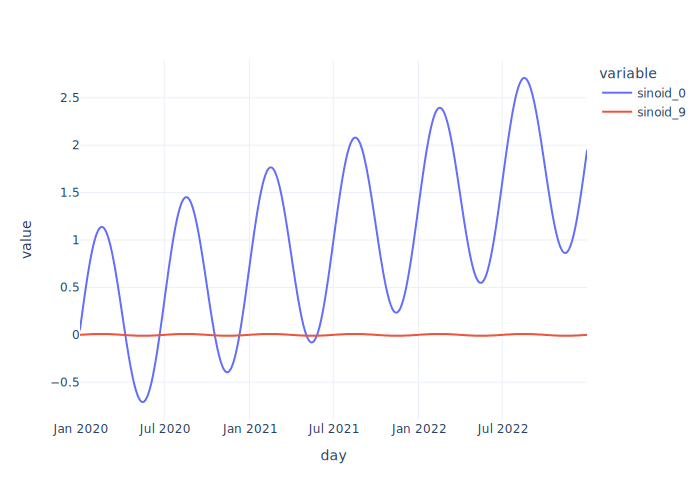

In [4]:
px.line(data[["sinoid_0", "sinoid_9"]])

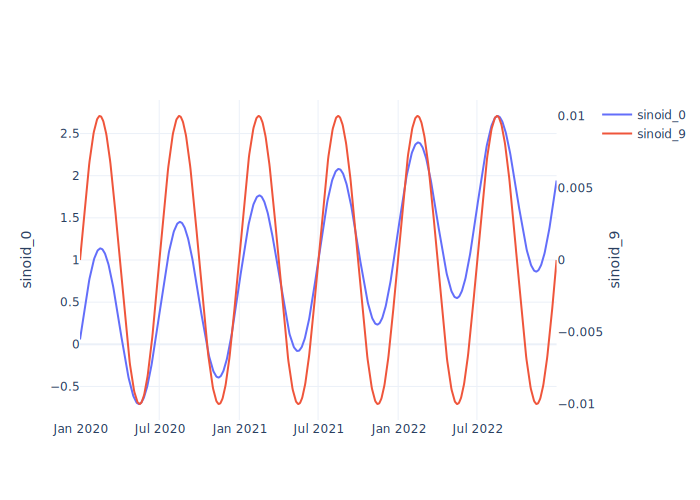

In [5]:
fig = px.line(data[["sinoid_0", "sinoid_9"]]).dual()
fig

# Year-over-year comparisons
Lets try to overlay the data from different years

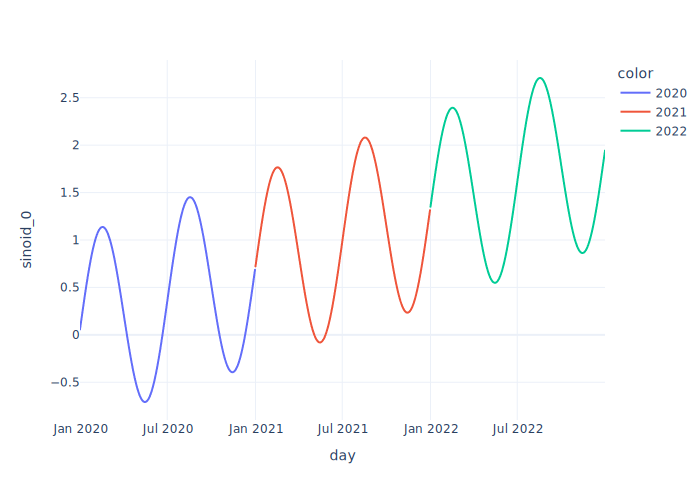

In [6]:
fig = px.line(data, y="sinoid_0", color=data.index.year)
fig


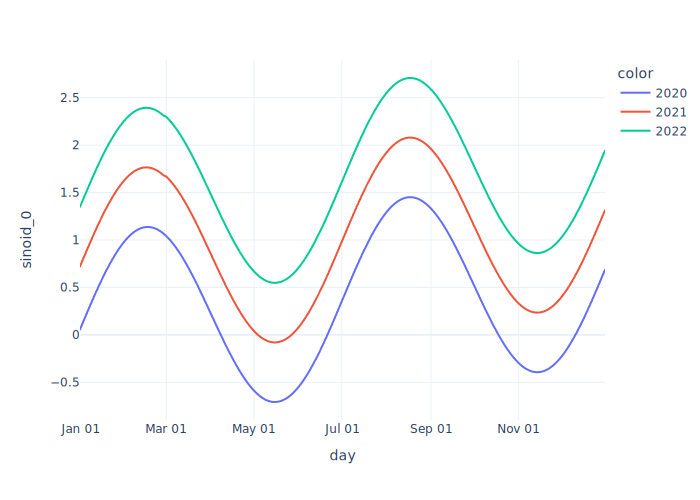

In [7]:
fig.yoy()

# Multiple colors in a single line
When we want a single line, we want to compare a before and after scenario.
If you use the `color` argument, plotly will generate two separate lines

In [8]:
single_line_example = data.assign(is_january=lambda df: df.index.month == 1)

fig = px.line(
    single_line_example,
    y="sinoid_0",
    color="is_january",
)


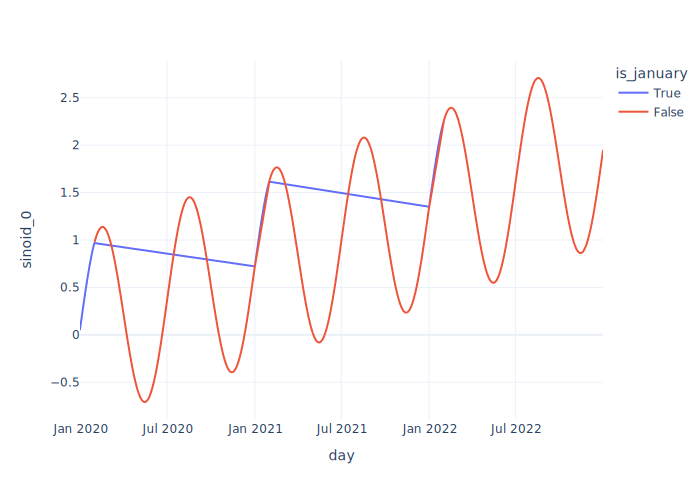

In [9]:
fig

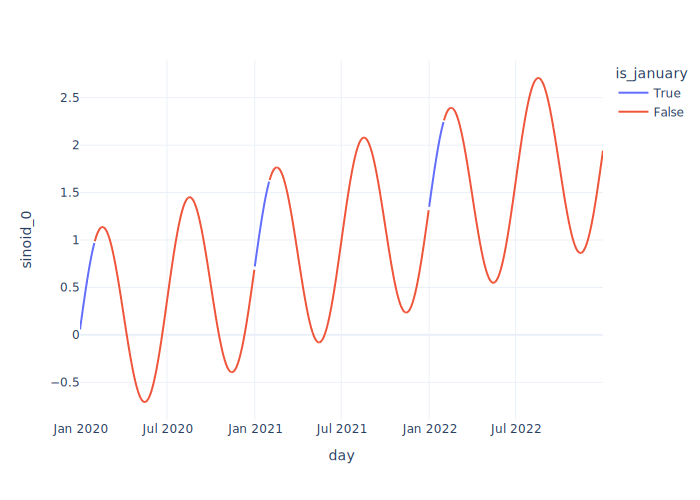

In [10]:
fig.single_line()

# Multiple lines as continuous color
When you have multiple lines, plotly has no easy way to color them using a variable like a continuous measure.
By default, Plotly will use it as a discrete variable.

In [11]:
tall_format = data.reset_index().melt(id_vars='day')
tall_format.head()


,day,variable,value
0,2020-01-01,sinoid_0,0.057522
1,2020-01-02,sinoid_0,0.093665
2,2020-01-03,sinoid_0,0.129767
3,2020-01-04,sinoid_0,0.165788
4,2020-01-05,sinoid_0,0.201687


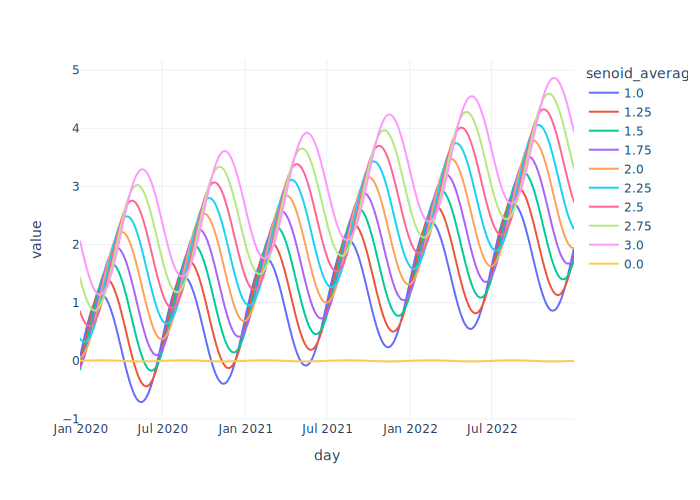

In [12]:
tall_format["senoid_average"] = (
    tall_format.groupby("variable")["value"].transform("mean").round(2)
)
fig = px.line(tall_format, x="day", y="value", color="senoid_average")
fig


The workaround is to change manually the color attribute of the traces.

Thats wrapped in `plasma.continuous_color`

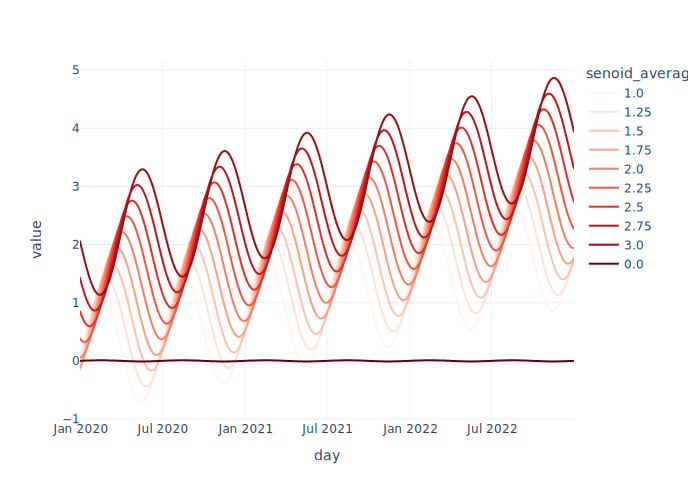

In [13]:
fig.continuous_color(colorscale="Reds")


# Facets
Default facets have a terrible `column_name=column_value` labels for y-axis, and they also share the same scale.
Let reshape our data and increase the length the names of the fields.

In [33]:
tall_format = (
    data[["sinoid_0", "sinoid_8", "sinoid_9"]]
    .reset_index()
    .melt(id_vars="day")
    .assign(
        is_even=lambda df: (
            df.variable.str.split("_", expand=True)[1].astype(int) % 2 == 0
        ).map({True: "even", False: "odd"}),
        variable=lambda df: "column_" + df.variable,
    )
)
tall_format.head()

,day,variable,value,is_even
0,2020-01-01,column_sinoid_0,0.057522,even
1,2020-01-02,column_sinoid_0,0.093665,even
2,2020-01-03,column_sinoid_0,0.129767,even
3,2020-01-04,column_sinoid_0,0.165788,even
4,2020-01-05,column_sinoid_0,0.201687,even


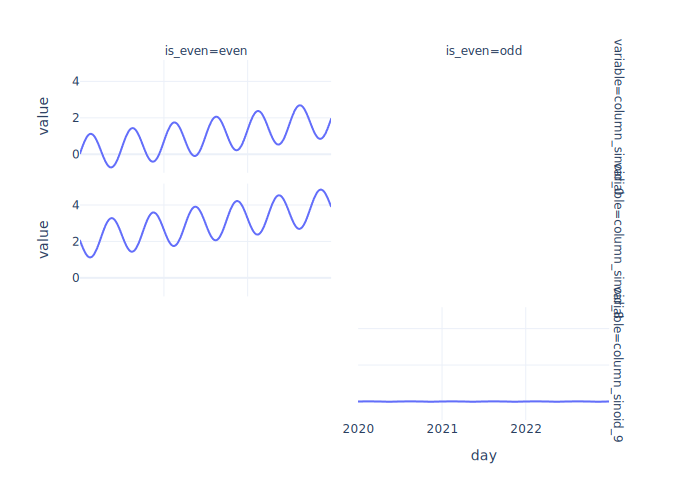

In [37]:
fig = px.line(
    tall_format,
    x="day",
    y="value",
    facet_row="variable",
    facet_col="is_even",
    facet_col_spacing=0.05,
)
fig

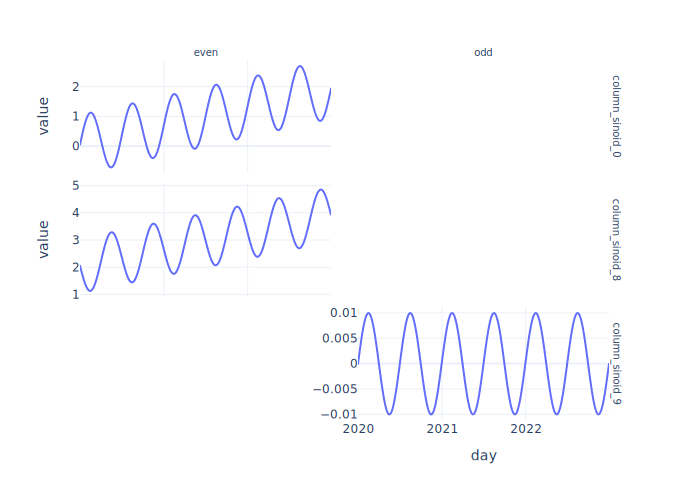

In [38]:
fig.fix_facet_labels(font_size=10).update_yaxes(matches=None, showticklabels=True)